# [NTDS'17] assignment 2: network models
[ntds'17]: https://github.com/mdeff/ntds_2017

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](http://lts4.epfl.ch)

For this assignment we will work on a network representing the collaboration between scientists in the field of General Relativity and Quantum Cosmology. The network comes from [SNAP](http://snap.stanford.edu/data/ca-GrQc.html) and is described as follows:

> Arxiv GR-QC (General Relativity and Quantum Cosmology) collaboration network is from the e-print [arXiv](https://arxiv.org) and covers scientific collaborations between authors papers submitted to General Relativity and Quantum Cosmology category. If an author *i* co-authored a paper with author *j*, the graph contains a undirected edge from *i* to *j*. If the paper is co-authored by *k* authors this generates a completely connected (sub)graph on *k* nodes. The data covers papers in the period from January 1993 to April 2003 (124 months). It begins within a few months of the inception of the arXiv.

In [1]:
%matplotlib inline

import os
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
G = nx.read_edgelist(os.path.join('..', 'data', 'arxiv_collaboration_network.txt'))

In [3]:
print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

My network has 5242 nodes.
My network has 14496 edges.


## 1. Comparing to model networks

1.1 In this part of the assignment, you have to create an Erdős–Rényi and Barabási-Albert graph using NetworkX, and compare them to the collaboration network. Try to simulate the original network as best as you can. When choosing parameters for the networks, take into account the number of vertices and edges of the original network. The number of vertices should be exactly the same. Comment on your choice of parameters.

In [4]:
n = len(G.nodes())
m = G.size()
p = m*2/(n*(n-1))
er=nx.erdos_renyi_graph(n,p)
ba=nx.barabasi_albert_graph(n,3)

For the ER network, the expected number of edges is $$E[m] = pn(n-1)/2.$$
For the BA network, m is fixed to $$m = q*(n-q),$$ where $q$ is the model parameter. 

Since $q$ had to be a natural number, $q=3$ gives the best approximation.

In [5]:
print('My Erdos Renyi network has {} nodes.'.format(len(er.nodes())))
print('My Erdos Renyi network has {} edges.'.format(er.size()))
print('My Barabasi Albert network has {} nodes.'.format(len(ba.nodes())))
print('My Barabasi Albert network has {} edges.'.format(ba.size()))

My Erdos Renyi network has 5242 nodes.
My Erdos Renyi network has 14368 edges.
My Barabasi Albert network has 5242 nodes.
My Barabasi Albert network has 15717 edges.


1.2 Check the size of the largest connected component in each graph and compare them to the original network. In the Erdős–Rényi model, what should the probability of creating each edge be in order to have the same expected size of the largest component? Justify. Generate a graph with this parameter to check if you indeed get a similar value.

In [6]:
giant_G = max(nx.connected_component_subgraphs(G), key=len)
giant_er = max(nx.connected_component_subgraphs(er), key=len)
giant_ba = max(nx.connected_component_subgraphs(ba), key=len)
print(len(giant_G.nodes()))
print(len(giant_er.nodes()))
print(len(giant_ba.nodes()))

4158
5223
5242


We know from the lectures that in Erdős–Rényi networks, the fraction of nodes in the giant component $$S = \frac{N_G}{N}$$ grows with the average degree by $$S = 1 - e^{-\langle k \rangle S}.$$ Therefore, as $\langle k \rangle = (N-1)p$:

In [7]:
S_G = len(giant_G.nodes())/n
p_giant = - np.log(1-S_G)/((n-1)*S_G)
print('The parameter p for an Erdos Renyi network with the same expected size of the giant component is {}.'.format(p_giant))

er_giant = max(nx.connected_component_subgraphs(nx.erdos_renyi_graph(n,p_giant)), key=len)
print('The size of the component in a randomly generated network with this parameter is {}.'.format(len(er_giant.nodes())))

The parameter p for an Erdos Renyi network with the same expected size of the giant component is 0.00037911157202514926.
The size of the component in a randomly generated network with this parameter is 4157.


1.3 Look at the clustering coefficient of the original network. Is there a network model we talked about that could have a clustering coefficient that is close? Explain.

In [8]:
nx.average_clustering(G)

0.529635811052136

Yes, the Watts - Strogatz model can have a very high clustering coefficient with the similar number of vertices and edges. This coefficient can be decreased with a high rewiring parameter, leaving the number of vertices and edges the same.

## 2. Creating a network with a predefined degree distribution

In this part of the assignment, you will have to create a random network from a predefined degree distribution. There are several network models which can create a random network with the exact same degree distribution as the original, or with the same expected distribution as the original. Refer to section 4.8 of [the Barabási book](http://networksciencebook.com) for more information.

One of the most famous ones is the configuration model. The model for a graph with $L$ edges in total is constructed in the following steps:

- Assign a degree to each node, represented as stubs (half-links). The degree sequence is either generated analytically from a preselected distribution, or it is extracted from the adjacency matrix of a real network. Note that we must start from an even number of stubs to avoid being left with unpaired stubs.
- Randomly select a stub pair and connect them. Then randomly choose another pair from the remaining $2L - 2$ stubs and connect them. This procedure is repeated until all stubs are paired up.

*Reminder:* A stub is a half-link, representing the half of an edge. It contains one node and can be paired up with another stub to create an edge (between the two corresponding nodes).

2.1 However, this model allows for the creation of multi-links (multiple edges between the same pair of vertices) and self-loops, thus leading to a non-simple graph. In this assignment, you will implement a greedy configuration model, to avoid these problems.

2.1 However, this model allows for the creation of multi-links (multiple edges between the same pair of vertices) and self-loops, thus leading to a non-simple graph. In this assignment, you will implement a greedy configuration model, to avoid these problems.

The algorithm goes as follows:
- Extract the degree sequence from our collaboration network.
- Assign a target degree to each node, represented as stubs or half-links. Use the degree sequence extracted from the collaboration network.
- Sort the nodes by degree. 
    - Pick the node with the highest target degree. Delete all its stubs from the list of stubs to make sure we don't create a self loop.
    - Until all its weighted degree equals its target degree: 
        - Randomly select one stub from the list of stubs (corresponding to one of the other nodes), and connect these two nodes. In case the two chosen nodes are already connected, simply increase the weight of this edge by one. Be careful to randomly select from stubs and not from nodes, as this means the chances of selecting a node will be proportional to its target degree.
    - When the number of edges adjacent to this node corresponds to its target degree, go on to the second node in the list. 
    - Repeate this procedure until all stubs are paired up, or there is only one node left with a pair number of stubs. In that case, don't create a self-loop, but discard the stubs.
    
*Hints*: 
 - Use `nx.empty_graph()` to create an empty graph.
 - Use `G.add_edge(node1,node2,weight = 1)` to add an edge to a weighted graph.
 - Use `G.edge[node1][node2]['weight'] += 1` to increment the weight of an edge by one.

In [9]:
def greedy_configuration(degree_distribution):
    N=len(degree_distribution)
    G=nx.empty_graph()

    degree_distribution = sorted(degree_distribution,reverse=True)
    stublist=[]
    for node in range(len(degree_distribution)):
        for i in range(degree_distribution[node]):
            stublist.append(node) 
    
    for node in range(len(degree_distribution)):
        for stub in range(degree_distribution[node]):
            del stublist[0]
        while(degree_distribution[node] and len(stublist) > 0):
            ind = np.random.randint(0,len(stublist))
            b = stublist.pop(ind)
            if G.has_edge(node,b):
                G.edge[node][b]['weight'] += 1
            else:
                G.add_edge(node,b,weight = 1)
            
            degree_distribution[node] = degree_distribution[node] - 1
            degree_distribution[b] = degree_distribution[b] - 1
    return G

In [10]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence
gc = greedy_configuration(degree_sequence)

2.2 Verify that the networks have the same number of nodes. Plot the difference between the weighted degree distributions to verify that they are identical. If not, why?

My network has 5242 nodes.


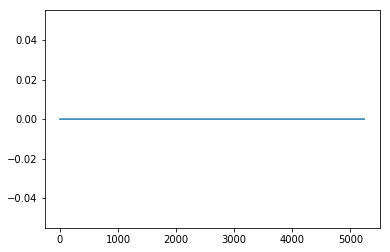

In [11]:
print('My network has {} nodes.'.format(len(gc.nodes())))
degree_sequence_gc=sorted(nx.degree(gc, weight = 'weight').values(),reverse=True)
plt.plot(np.array(degree_sequence) - np.array(degree_sequence_gc));

The number of nodes and weighted distributions are the same. However, they could've been different in case our algorithm finished with just one node and a pair number of stubs.

2.3 Should these two networks have the same adjacency matrices? Justify.

No, the configuration model only tries to ensure the weighted degree distributions are the same. However, it still chooses connections between nodes randomly and there is no reason to expect the same structure. Having the same adjacency matrices would mean having identical graphs. In addition, having the same weighted degrees doesn't even guarantee the same number of neighbors for corresponding nodes.

2.4 Draw both the generated and original networks. Are they similar? If not, why? Try to explain.

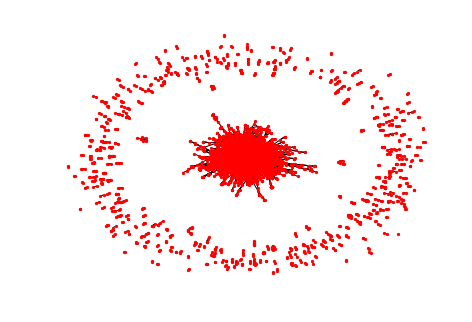

In [12]:
nx.draw(G,node_size = 5)

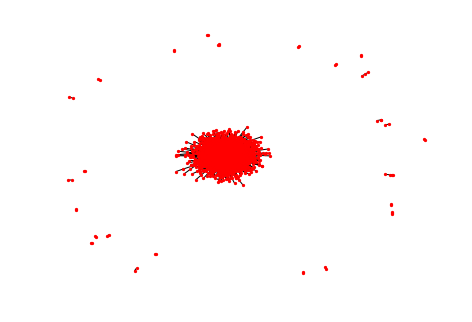

In [13]:
nx.draw(gc,node_size = 5)

Not really. We can see that the random graph has a much larger giant component. This is due to the special structure of the collaboration graph, with a lot of well connected small groups that collaborate within, but not to the outside. The random model couldn't capture this structure.

2.5 Do you expect the properties studied in the first part of the assignment to be close to the original graph? Justify.

We expect the number of nodes and edges to be similar by design. However, as we've seen in ex 2.4, the size of the giant component is quite larger. As for the clustering coefficient, we know from the first part that the original graph has a very large clustering coefficient. Therefore, we don't expect the random graph to have a similar value.